


**DATASET**

Number of Samples: 109446
Number of Categories: 5
Sampling Frequency: 125Hz
Data Source: Physionet's MIT-BIH Arrhythmia Dataset
Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]




0.  **Normal Heartbeats**
1.  **Supraventracular Heartbeats**
2.  **Ventricular ectopic beats**
3.  **Fusion Beats**
4.  **Unknown Beats**

***Mounting Google Drive and importing dataset***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/mit_bih/mitbih_train.csv.zip
!unzip drive/MyDrive/mit_bih/mitbih_test.csv.zip

Archive:  drive/MyDrive/mit_bih/mitbih_train.csv.zip
  inflating: mitbih_train.csv        
Archive:  drive/MyDrive/mit_bih/mitbih_test.csv.zip
  inflating: mitbih_test.csv         


***Importing needed libraries***

In [ ]:
import pandas as pd
import numpy as np
import keras as k
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import scipy.signal as sig
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, BatchNormalization, Dropout
from keras.models import load_model

***Defining needed functions***

In [ ]:
def load_train_data():
  data = pd.read_csv("mitbih_train.csv", header = None)
  return data

In [ ]:
def load_test_data():
  test = pd.read_csv("mitbih_test.csv", header = None)
  return test

In [ ]:
def visualise_data_samples(data):

  df0 = data[data[data.shape[1]-1] == 0]
  df1 = data[data[data.shape[1]-1] == 1]
  df2 = data[data[data.shape[1]-1] == 2]
  df3 = data[data[data.shape[1]-1] == 3]
  df4 = data[data[data.shape[1]-17] == 4]

  figure, axs = plt.subplots(2, 2, constrained_layout=True)
  axs[0,0].plot(df0.iloc[0, 0:data.shape[1]-1], color = 'green')
  axs[0,0].set_title('Normal beat')
  axs[0,1].plot(df1.iloc[0, 0:data.shape[1]-1], color = 'blue')
  axs[0,1].set_title('Supraventricular ectopic beat')
  axs[1,0].plot(df2.iloc[0, 0:data.shape[1]-1], color = 'red')
  axs[1,0].set_title('Ventricular ectopic beat')
  axs[1,1].plot(df3.iloc[0, 0:data.shape[1]-1], color = 'orange')
  axs[1,1].set_title('Fusion Beat')
  #axs[2,0].plot(df4.iloc[0, 0:data.shape[1]-1], color = 'yellow')
  #axs[2,0].set_title('Unknown Beats')
  sns.set_style("whitegrid")
  plt.show()

  plt.figure(figsize=(20,8))
  plt.plot(df0.iloc[0, 0:data.shape[1]-1], color = 'green', label = 'Normal Heart Beats')
  plt.plot(df1.iloc[0, 0:data.shape[1]-1], color = 'blue', label = 'Supraventricular ectopic beats')
  plt.plot(df2.iloc[0, 0:data.shape[1]-1], color = 'red', label='Ventricular ectopic beats')
  plt.plot(df3.iloc[0, 0:data.shape[1]-1], color = 'orange', label='Fusion Beats')
  plt.ylabel("Heart Beat Amplitude")
  plt.legend()
  plt.show()

In [ ]:
def train_val_split(data, ratio):
  data[data.shape[1]-1] = data[data.shape[1]-1].astype('int')
  data = data.sample(frac=1, random_state=123)
  if 0 < ratio < 1 :
    train_data = data.iloc[:int(data.shape[0] * ratio),:]
    val_data = data.iloc[int(data.shape[0] * ratio):,:]
    return train_data, val_data
  else:
    print("Wrong fraction provided")

In [ ]:
def resample_train_data(train_data, samples, with_visualisation):
  df0 = train_data[train_data[train_data.shape[1]-1] == 0]
  df1 = train_data[train_data[train_data.shape[1]-1] == 1]
  df2 = train_data[train_data[train_data.shape[1]-1] == 2]
  df3 = train_data[train_data[train_data.shape[1]-1] == 3]
  df4 = train_data[train_data[train_data.shape[1]-1] == 4]

  if with_visualisation:
    print("Training data partitioning before resampling")
    labels = 'Normal Beats','Supraventricular ectopic beats','Ventricular ectopic beats','Fusion Beats','Unknown Beats'
    sizes = [df0.shape[0], df1.shape[0], df2.shape[0], df3.shape[0], df4.shape[0]]
    colors = ['green','orange','blue','magenta','cyan']
    explode = (0.1, 0, 0, 0, 0)  # explode 1st slice

    plt.figure(figsize=(10,10))
    patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
    plt.legend(patches, labels, loc="best",fontsize=18)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

  df0_downsample = resample(df0, n_samples = samples, replace = True, random_state = 123)
  df1_upsample = resample(df1, n_samples = samples, replace = True, random_state = 123)
  df2_upsample = resample(df2, n_samples = samples, replace = True, random_state = 123)
  df3_upsample = resample(df3, n_samples = samples, replace = True, random_state = 123)
  df4_upsample = resample(df4, n_samples = samples, replace = True, random_state = 123)
  resampled_train_data = pd.concat([df0_downsample, df1_upsample, df2_upsample, df3_upsample, df4_upsample])
  resampled_train_data = resampled_train_data.sample(frac=1, random_state=123)

  if with_visualisation:
    print("Training data partitioning after resampling")
    labels = 'Normal Beats','Supraventricular ectopic beats','Ventricular ectopic beats','Fusion Beats','Unknown Beats'
    sizes = [df0_downsample.shape[0], df1_upsample.shape[0], df2_upsample.shape[0], df3_upsample.shape[0], df4_upsample.shape[0]]
    colors = ['green','orange','blue','magenta','cyan']
    explode = (0.1, 0, 0, 0, 0)  # explode 1st slice

    plt.figure(figsize=(10,10))
    patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90)
    plt.legend(patches, labels, loc="best",fontsize=18)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

  return resampled_train_data


In [ ]:
def add_gaussian_noise(ecg_signal):
  gaussian_noise = np.random.normal(0,0.05,ecg_signal.shape[0])
  return ecg_signal + gaussian_noise

In [ ]:
def stretch(ecg_signal):
  nb_samples = int(ecg_signal.shape[0] * (1 + (random.random()-0.5)/2))
  new_signal = sig.resample(ecg_signal, nb_samples)
  if nb_samples < ecg_signal.shape[0]:
    padding = np.zeros(ecg_signal.shape[0] - len(new_signal))
    new_signal = np.concatenate((new_signal,padding))
  else:
    new_signal = new_signal[:ecg_signal.shape[0]]
  return new_signal

In [ ]:
def amplify(ecg_signal):
  number = random.random() * 0.5
  factor = -number * ecg_signal + (1+number)
  return ecg_signal * factor

In [ ]:
def visualise_augmentation_operations(ecg_signal):
  sns.set_style("whitegrid")
  plt.figure(figsize=(12,6))
  plt.plot(ecg_signal, color = 'blue', label='ECG before adding noise')
  plt.plot(add_gaussian_noise(ecg_signal), color = 'green', label = 'ECG after adding noise')
  plt.ylabel("Heart Beat Amplitude")
  plt.legend()
  plt.show()

  sns.set_style("whitegrid")
  plt.figure(figsize=(12,6))
  plt.plot(ecg_signal, color = 'blue', label='ECG before stretching')
  plt.plot(stretch(ecg_signal), color = 'green', label = 'ECG after stretching')
  plt.ylabel("Heart Beat Amplitude")
  plt.legend()
  plt.show()

  sns.set_style("whitegrid")
  plt.figure(figsize=(12,6))
  plt.plot(ecg_signal, color = 'blue', label='ECG before amplification')
  plt.plot(amplify(ecg_signal), color = 'green', label = 'ECG after amplification')
  plt.ylabel("Heart Beat Amplitude")
  plt.legend()
  plt.show()


In [ ]:
def augment_ecg_data(ecg):
  rand_number = random.random()
  if rand_number < 1/9:
    augmented_ecg = add_gaussian_noise(ecg)
  elif rand_number < 2/9:
    augmented_ecg = stretch(ecg)
  elif rand_number < 3/9:
    augmented_ecg = amplify(ecg)
  elif rand_number < 4/9:
    augmented_ecg = ecg
  elif rand_number < 5/9:
    augmented_ecg = amplify(stretch(ecg))
  elif rand_number < 6/9:
    augmented_ecg = add_gaussian_noise(amplify(ecg))
  elif rand_number < 8/9 :
    augmented_ecg = add_gaussian_noise(stretch(ecg))
  else :
    augmented_ecg = add_gaussian_noise(amplify(stretch(ecg)))
  return augmented_ecg 

In [ ]:
def preprocess_data(train_data, val_data, with_visualisation):
  
  train_data = resample_train_data(train_data, 20000, with_visualisation)
  
  Y_train = tf.keras.utils.to_categorical(train_data[train_data.shape[1]-1])
  Y_val =  tf.keras.utils.to_categorical(val_data[val_data.shape[1]-1])
  X_train = train_data.iloc[:, :-1].values
  X_val = val_data.iloc[:, :-1].values

  for i in range(X_train.shape[0]):
    X_train[i] = augment_ecg_data(X_train[i])
  
  X_train = X_train.reshape(len(X_train),X_train.shape[1],1)
  X_val = X_val.reshape(len(X_val),X_val.shape[1],1)

  return X_train, Y_train, X_val, Y_val

In [ ]:
def build_model(input):
    model = k.Sequential()
    model.add(Conv1D(128, 50, strides=1,activation="relu", input_shape=input))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=1, padding="valid"))
    model.add(Conv1D(32, 7, strides=1,activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=1, padding="valid"))
    model.add(Conv1D(32, 10, strides=1,activation="relu"))
    model.add(Conv1D(128, 5, strides=1,activation="relu"))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding="valid"))
    model.add(Conv1D(256, 15, strides=1,activation="relu"))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding="valid"))
    model.add(Conv1D(512, 5, strides=1,activation="relu"))
    model.add(Conv1D(128, 3, strides=1,activation="relu"))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(units = 512, activation='relu'))
    model.add(Dense(units = 5, activation='softmax'))
    model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [ ]:
def train_model(model, X_train, Y_train, X_val, Y_val, epoch_number, batches):

  # setting up callbacks to store the model with the best validation accuracy during training
  filepath = 'drive/MyDrive/best_model.hdf5'
  checkpoint = k.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  callbacks = [checkpoint]

  #training the model
  history = model.fit(X_train, Y_train, epochs = epoch_number, batch_size = batches, validation_data=(X_val, Y_val), callbacks=callbacks)

  #visualise accuracy and loss
  pd.DataFrame(history.history)
  pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
  pd.DataFrame(history.history)[['loss', 'val_loss']].plot()


In [ ]:
def prepare_test_data(test_data):
  test_data = test_data.sample(frac=1, random_state=123)
  test_data[test_data.shape[1]-1] = test_data[test_data.shape[1]-1].astype('int')
  Y_test = tf.keras.utils.to_categorical(test_data[test_data.shape[1]-1])
  X_test = test_data.iloc[:, :-1].values
  X_test = X_test.reshape(len(X_test),X_test.shape[1],1)
  return X_test, Y_test

In [ ]:
def show_confusion_matrix(test_data):
  df0_test = test_data[test_data[test_data.shape[1]-1] == 0]
  df1_test = test_data[test_data[test_data.shape[1]-1] == 1]
  df2_test = test_data[test_data[test_data.shape[1]-1] == 2]
  df3_test = test_data[test_data[test_data.shape[1]-1] == 3]
  df4_test = test_data[test_data[test_data.shape[1]-1] == 4]
  df0_test = resample(df0_test, n_samples = 2000, replace = True, random_state= 123)
  test_data = pd.concat([df0_test, df1_test, df2_test, df3_test, df4_test])
  test_data = test_data.sample(frac=1, random_state=123)
  X_test = test_data.drop([test_data.shape[1]-1], axis=1) 
  Y_test = test_data[test_data.shape[1]-1]
  X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
  m = load_model('drive/MyDrive/best_model.hdf5')
  Y_predictions = m.predict(X_test)
  Y_pred_labels = [np.where(i == np.max(i))[0][0] for i in Y_predictions]
  matrix = confusion_matrix(Y_test, Y_pred_labels)
  classes=['N', 'S', 'V', 'F', 'Q']
  fig, ax = plt.subplots(figsize=(11,10))
  ax1 = sns.heatmap(matrix, annot=True, linewidths=0.5, xticklabels=classes, yticklabels=classes)
  ax1.set(xlabel="Predicted Label", ylabel = "True Label")


***Function to create some CSV file samples for testing individual ECG heartbeats***

In [ ]:
def create_sample_CSVs(test_data):
  test_data[test_data.shape[1]-1] = test_data[test_data.shape[1]-1].astype('int')
  df0_test = test_data[test_data[test_data.shape[1]-1] == 0]
  df0_test = df0_test.sample(frac=1)
  df1_test = test_data[test_data[test_data.shape[1]-1] == 1]
  df1_test = df1_test.sample(frac=1)
  df2_test = test_data[test_data[test_data.shape[1]-1] == 2]
  df2_test = df2_test.sample(frac=1)  
  df3_test = test_data[test_data[test_data.shape[1]-1] == 3]
  df3_test = df3_test.sample(frac=1)  
  df4_test = test_data[test_data[test_data.shape[1]-1] == 4]
  df4_test = df4_test.sample(frac=1)
  test_classes = [df0_test, df1_test, df2_test, df3_test, df4_test]
  random.shuffle(test_classes)
  os.mkdir('samples')
  i=0
  for c in test_classes:
    rand1 = random.random()
    rand2 = random.random()

    sample1 = pd.DataFrame(c.iloc[int(rand1*c.shape[0])-1]).transpose()
    sample2 = pd.DataFrame(c.iloc[int(rand2*c.shape[0])-1]).transpose()
    sample1.to_csv("samples/sample_"+str(i)+".csv", header=False, index=False)
    i = i+1
    sample2.to_csv("samples/sample_"+str(i)+".csv", header=False, index=False)
    i = i+1

In [ ]:
def predict_ecg_class(ecg):
  X_ecg = ecg.iloc[:,:ecg.shape[1]-1]
  X_ecg = ecg.iloc[:, :-1].values
  X_ecg = X_ecg.reshape(len(X_ecg),X_ecg.shape[1],1)
  Y_ecg = ecg.iloc[:,ecg.shape[1]-1]

  print("Predicted class : "+str(np.argmax(best_model.predict(X_ecg), axis=-1)))
  print("Actual class    : "+str(int(Y_ecg)))

***Loading data and visualising samples***

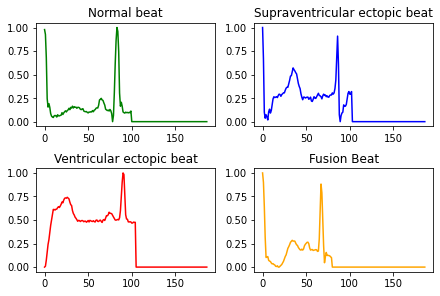

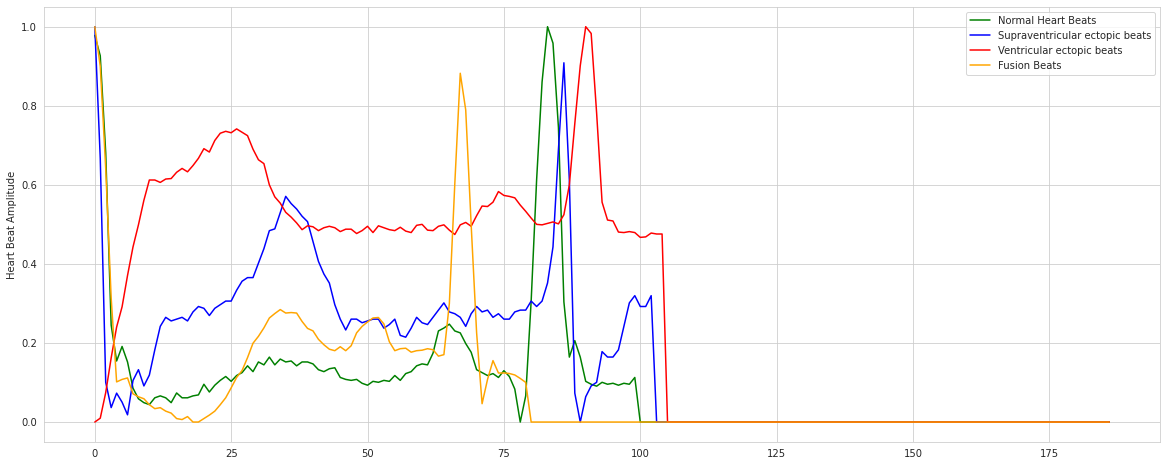

In [ ]:
data = load_train_data()
visualise_data_samples(data)

***Visualising data augmentation operations on some heartbeat samples***

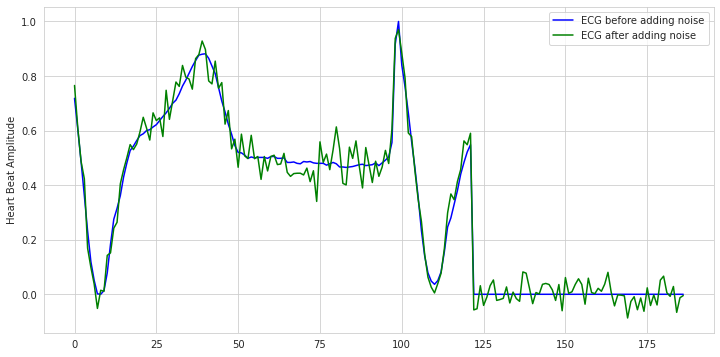

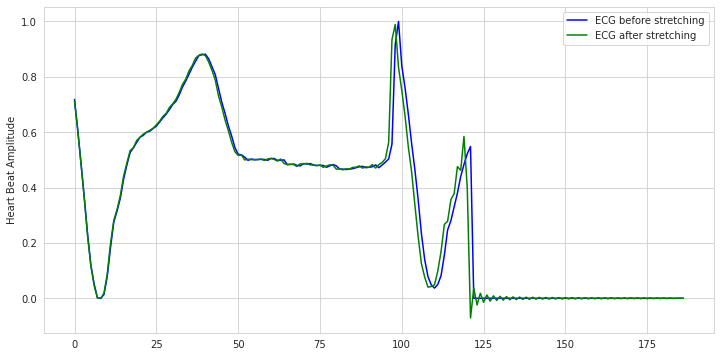

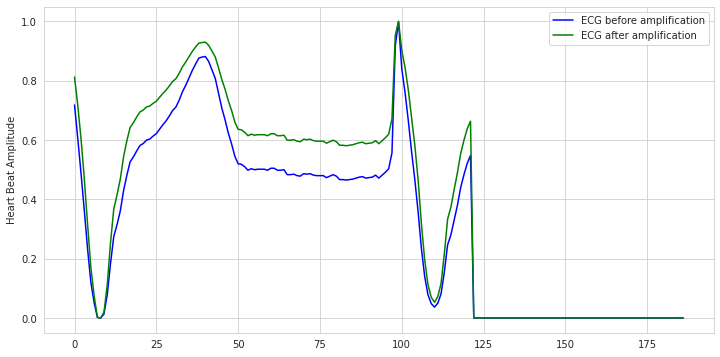

In [ ]:
ecg_sample = data.iloc[87550,:data.shape[1]-1]
visualise_augmentation_operations(ecg_sample)

***Split data into training and validation and apply preprocessing***

In [ ]:
train_data, val_data = train_val_split(data, 0.8)

Training data partitioning before resampling


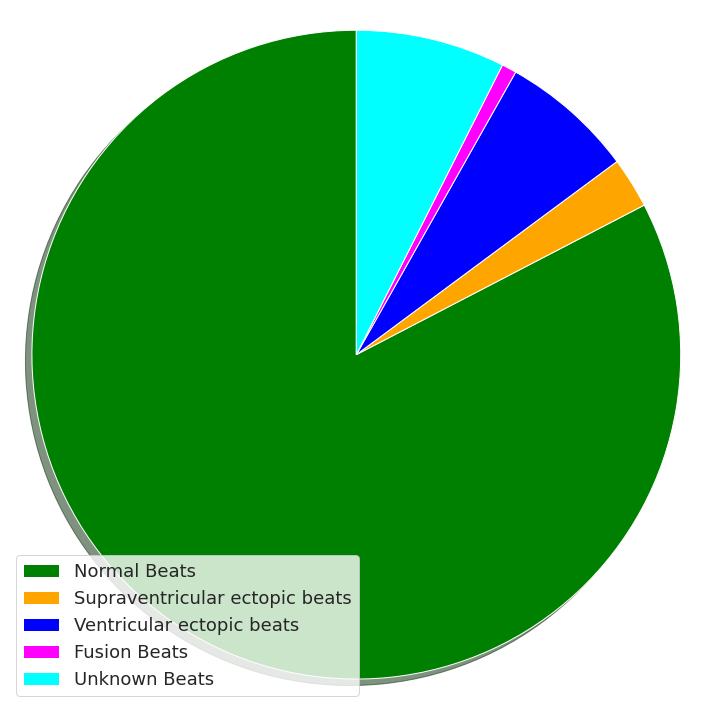

Training data partitioning after resampling


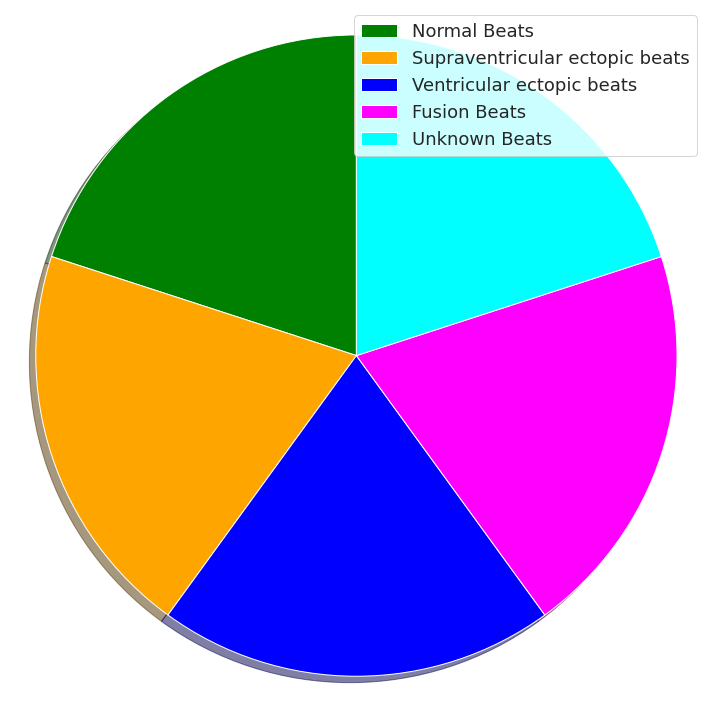

In [ ]:
X_train, Y_train, X_val, Y_val = preprocess_data(train_data, val_data, True)

***Building and training the model***

In [ ]:
model = build_model(input=(X_train.shape[1],1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 138, 128)          6528      
_________________________________________________________________
batch_normalization (BatchNo (None, 138, 128)          512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 137, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 131, 32)           28704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 131, 32)           128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 130, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 121, 32)           1

Epoch 1/50
3125/3125 [==============================] - 95s 15ms/step - loss: 0.6877 - accuracy: 0.7397 - val_loss: 0.4053 - val_accuracy: 0.8488

Epoch 00001: val_accuracy improved from -inf to 0.84878, saving model to drive/MyDrive/best_model.hdf5
Epoch 2/50
3125/3125 [==============================] - 50s 16ms/step - loss: 0.3416 - accuracy: 0.8774 - val_loss: 0.4681 - val_accuracy: 0.8384

Epoch 00002: val_accuracy did not improve from 0.84878
Epoch 3/50
3125/3125 [==============================] - 50s 16ms/step - loss: 0.2838 - accuracy: 0.8993 - val_loss: 0.3003 - val_accuracy: 0.8971

Epoch 00003: val_accuracy improved from 0.84878 to 0.89709, saving model to drive/MyDrive/best_model.hdf5
Epoch 4/50
3125/3125 [==============================] - 47s 15ms/step - loss: 0.2412 - accuracy: 0.9149 - val_loss: 0.2347 - val_accuracy: 0.9187

Epoch 00004: val_accuracy improved from 0.89709 to 0.91874, saving model to drive/MyDrive/best_model.hdf5
Epoch 5/50
3125/3125 [====================

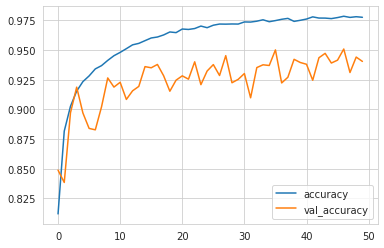

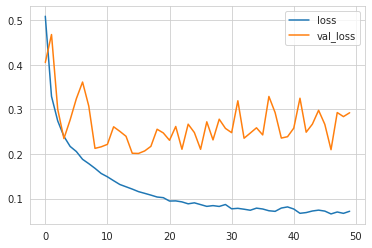

In [ ]:
train_model(model, X_train, Y_train, X_val, Y_val, 50, 32)

***Loading model with best accuracy from file***

In [ ]:
best_model = load_model('drive/MyDrive/best_model.hdf5')

***Evaluating the model using the test data***

In [ ]:
test_data = load_test_data()
X_test, Y_test = prepare_test_data(test_data)
best_model.evaluate(X_test, Y_test)

685/685 [==============================] - 46s 6ms/step - loss: 0.2081 - accuracy: 0.9503


[0.2080671191215515, 0.9503471851348877]

***Confusion matrix***

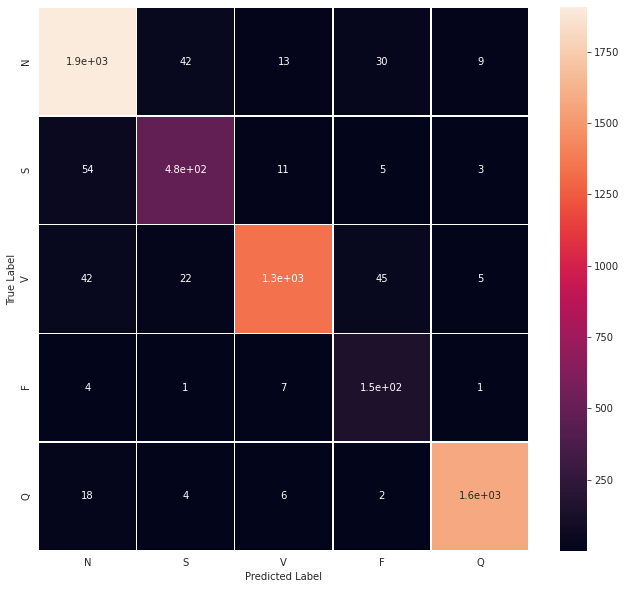

In [ ]:
show_confusion_matrix(test_data)

***Create CSV files containing random samples from test data***

In [ ]:
create_sample_CSVs(test_data)

***Testing some samples***

In [ ]:
for i in range(10):
  print('Sample '+str(i)+' : ')
  ecg = pd.read_csv('samples/sample_'+str(i)+'.csv', header=None)
  predict_ecg_class(ecg)
  print('\n')

Sample 0 : 
Predicted class : [2]
Actual class    : 2


Sample 1 : 
Predicted class : [2]
Actual class    : 2


Sample 2 : 
Predicted class : [3]
Actual class    : 3


Sample 3 : 
Predicted class : [3]
Actual class    : 3


Sample 4 : 
Predicted class : [0]
Actual class    : 0


Sample 5 : 
Predicted class : [0]
Actual class    : 0


Sample 6 : 
Predicted class : [4]
Actual class    : 4


Sample 7 : 
Predicted class : [4]
Actual class    : 4


Sample 8 : 
Predicted class : [1]
Actual class    : 1


Sample 9 : 
Predicted class : [1]
Actual class    : 1


